In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from os import chdir
import matplotlib.pyplot as plt

In [2]:
# Load input data, inflow-driven model:
stock_flow_timeseries = pd.read_excel(r'WEEE_generated_Tool_IE.xlsm', sheet_name='POM')
# Extract the relevant rows and columns

stock_flow_timeseries = stock_flow_timeseries.iloc[20,6:-9]
stock_flow_timeseries = stock_flow_timeseries.to_frame()

timesteps = range(1980,2023)

stock_flow_timeseries['year'] = timesteps

stock_flow_timeseries = stock_flow_timeseries.iloc[1:,:]
stock_flow_timeseries = stock_flow_timeseries.set_index('year')
stock_flow_timeseries = stock_flow_timeseries.rename(columns={20:'inflow'})


/opt/tljh/user/envs/bw25/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/opt/tljh/user/envs/bw25/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
print(stock_flow_timeseries)


        inflow
year          
1981   191.574
1982   209.692
1983   227.432
1984   245.402
1985   262.572
1986   278.983
1987   295.891
1988   311.018
1989   325.363
1990   341.245
1991   359.519
1992   379.035
1993   397.613
1994    415.56
1995   413.586
1996   424.835
1997   462.496
1998   501.279
1999   562.957
2000   626.955
2001   778.758
2002   685.988
2003   904.264
2004  1123.515
2005  1071.773
2006  1020.329
2007   973.329
2008   918.575
2009   805.559
2010    777.26
2011   747.461
2012   917.471
2013   976.284
2014  1094.138
2015  1272.742
2016  1456.963
2017  1376.206
2018  1416.225
2019  1452.931
2020  1486.004
2021  1687.912
2022   1741.44


In [4]:
time_max = stock_flow_timeseries.shape[0]
timesteps = np.arange(0, time_max)

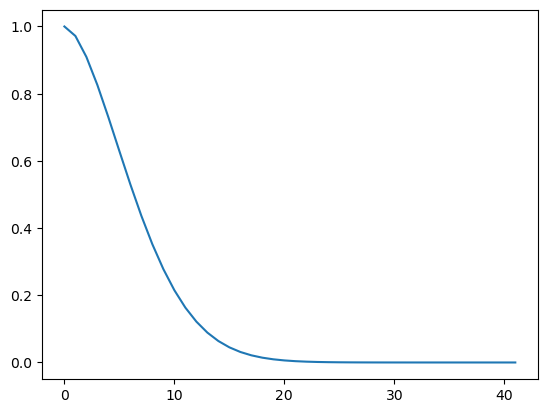

In [36]:
# Weibull distributed survival curve
# based on belgium 
curve_shape = 1.73
curve_scale = 7.8
curve_surv = scipy.stats.weibull_min.sf(timesteps, curve_shape, 0, curve_scale)
plt.plot(curve_surv)
curve_surv = curve_surv.astype(float)

In [6]:
print(curve_surv.dtype)

float64


In [7]:
# create survival curve matrix with placeholder zeros
curve_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)
#print(curve_surv_matrix)
# populate the survival curve matrix with shifted curves, column by column using slices

for time in timesteps:
    curve_surv_matrix.loc[time:, time] = curve_surv[0:time_max - time]

#print(curve_surv_matrix)

In [10]:
# create survival matrix with placeholder zeros
cohort_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)

# multiply the inflow times the shifted curves to get the cohorts' behavior over time

for time in timesteps:
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * stock_flow_timeseries['inflow'].iloc[time]

# set row index to years instead of timesteps
cohort_surv_matrix.index = stock_flow_timeseries.index

# calculate flows & stocks using the cohort_surv_matrix
stock_flow_timeseries['stock'] = cohort_surv_matrix.sum(axis=1)
stock_flow_timeseries['nas'] = np.diff(stock_flow_timeseries['stock'], prepend=0)  # prepending 0 assumes no initial stock
stock_flow_timeseries['outflow'] = stock_flow_timeseries['inflow'] - stock_flow_timeseries['nas']


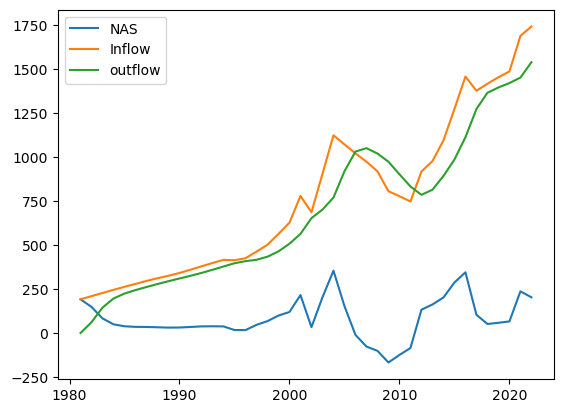

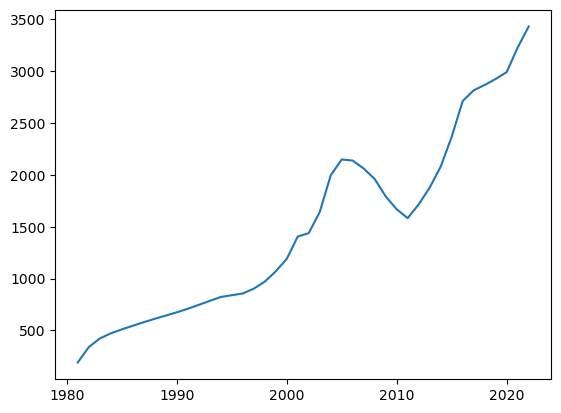

In [16]:
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['nas'], label = 'NAS')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['inflow'], label = 'Inflow')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.legend()
plt.show()
plt.close()
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['stock'], label = 'stock')

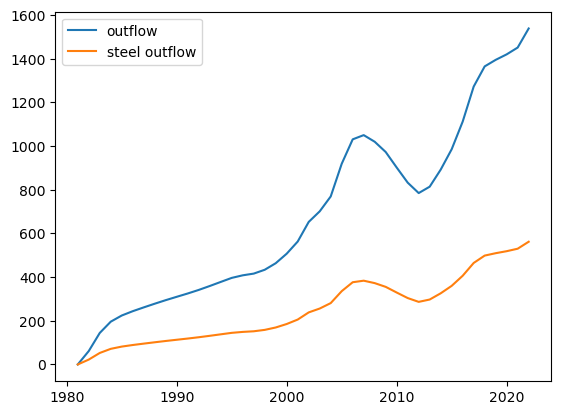

In [32]:
steel_intensity = 0.3653
steel_stock_flow_timeseries = stock_flow_timeseries*steel_intensity
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.legend()

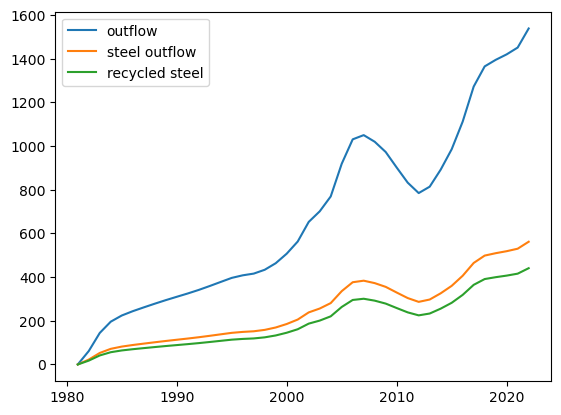

In [37]:
steel_recycle_efficiency = .784444
secondary_steel_stock_flow_timeseries = steel_stock_flow_timeseries*steel_recycle_efficiency


plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.plot(secondary_steel_stock_flow_timeseries.index,secondary_steel_stock_flow_timeseries['outflow'], label = 'recycled steel')
plt.legend()

In [34]:
secondary_steel_share = secondary_steel_stock_flow_timeseries['outflow']/steel_stock_flow_timeseries['inflow']
print(secondary_steel_share)

year
1981         0.0
1982    0.230188
1983    0.498068
1984     0.62663
1985    0.669936
1986    0.686082
1987    0.693081
1988    0.701914
1989     0.71019
1990    0.712408
1991    0.709325
1992    0.706553
1993    0.708876
1994    0.713508
1995    0.752013
1996    0.753835
1997     0.70575
1998    0.678653
1999    0.646113
2000    0.634837
2001    0.567108
2002    0.746462
2003    0.608314
2004    0.537174
2005    0.672619
2006     0.79258
2007    0.846411
2008    0.870934
2009     0.94737
2010    0.910053
2011    0.873791
2012    0.671051
2013    0.654155
2014    0.639657
2015    0.607487
2016    0.598805
2017    0.725355
2018    0.756011
2019    0.753087
2020    0.749622
2021    0.674415
2022    0.693033
dtype: object
